In [1]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 2.7 MB/s eta 0:00:00


In [2]:
!pip install pettingzoo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 10.1 MB/s eta 0:00:00


In [3]:
!pip install 'shimmy>=2.0'

In [4]:
!pip install modin[ray]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.8 MB/s eta 0:00:00


In [5]:
!pip install supersuit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.6/563.6 kB 20.7 MB/s eta 0:00:00


In [6]:
import numpy as np
import functools
from pettingzoo import AECEnv
from gymnasium import spaces
from pettingzoo.utils.agent_selector import AgentSelector
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [7]:
class KyleMultiPeriodAEC(AECEnv):

   # T-period Kyle model (discrete time, linear pricing) with two agents:
     # - insider chooses x_t  (R)
     # - market maker chooses lambda_t  (R_+), price: p_t = p_{t-1} + lambda_t * y_t
   # Noise order: u_t ~ N(0, sigma_u^2), order flow y_t = x_t + u_t.
   # State carried across periods: (v, p_{t-1}, sigma_v^2, sigma_u^2, sigma_{t-1}^2),
   # where sigma_{t-1}^2 is the MM’s posterior variance of v after seeing y_1..y_{t-1}.

   # Observations (as in picture):
     # insider:      (v, p_{t-1}, sigma_v^2, sigma_u^2, G_{t-1}^2)
    #  market maker: (p_{t-1}, sigma_v^2, sigma_u^2, y_t,       G_{t-1}^2)

   # Rewards each period:
     # insider: x_t * (v - p_t)
     # market_maker: -(p_t - v)**2   (squared-error pricing loss)

  #  Notes:
     # • lambda_t action is mapped to R_+ via softplus.
     # • In Kyle equilibrium G_t^2 = 0.5 * G_{t-1}^2; we update this way by default.
     # • If you later want Bayesian updating from realized (lambda_t, y_t), swap in a filter.


    metadata = {"render_modes": ["human"], "name": "KyleMultiPeriodAEC"}

    def __init__(
        self,
        sigma_v= 2.0,
        sigma_u = 1.0,
        p0 = 0.5,
        gamma = 0.9,
        action_scaling=5.0,
        lambda_scaling = 5.0,
        T = 25
    ):
        super().__init__()

        # Model params
        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.p0 = p0
        self.gamma = gamma
        self.T = T


        # Runtime state
        self.timestep = 0
        self.action_scaling = action_scaling
        self.lambda_scaling = lambda_scaling

        # Agents / PettingZoo bookkeeping
        self.possible_agents = ["insider", "market_maker"]
        self.agents = self.possible_agents[:]
        self.render_mode = None

        # Spaces

        self.action_spaces = {
            "insider": spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32),   # x_t (scaled)
            "market_maker": spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32),  # lambda_t (mapped -> R_+)
        }
        # insider: (v, p_{t-1}, sigma_v^2, sigma_u^2, sigma_{t-1}^2)
        # mm:      (p_{t-1}, sigma_v^2, sigma_u^2, y_t,        sigma_{t-1}^2)
        self.observation_spaces = {
            "insider": spaces.Box(low=-10, high=10, shape=(5,), dtype=np.float32),
            "market_maker": spaces.Box(low=-10, high=10, shape=(5,), dtype=np.float32),
        }

        # Will be set in reset()
        self.rewards = None
        self._cumulative_rewards = None
        self.terminations = None
        self.truncations = None
        self.infos = None
        self.agent_selector = AgentSelector(self.possible_agents)

    # ---------- PettingZoo API ----------
    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
        self.rewards = {a: 0.0 for a in self.agents}
        self._cumulative_rewards = {a: 0.0 for a in self.agents}
        self.terminations = {a: False for a in self.agents}
        self.truncations = {a: False for a in self.agents}
        self.infos = {a: {} for a in self.agents}
        self.timestep = 0

        # Draw true value and initialize beliefs
        self.v = float(np.random.normal(loc=self.p0, scale=self.sigma_v))  # v ~ N(p0, sigma_v)
        self.p_prev = float(self.p0)            # p_{t-1}
        self.sigma2_prev = float(self.sigma_v**2)   # sigma_{t-1}^2 (posterior var), start = prior var
        self.y_t = 0.0                          # will be set after insider moves
        self.u_t = 0.0

        # action placeholders for this period
        self.x_t = 0.0
        self.lambda_t = 0.0
        self.p_t = self.p_prev

        # start with insider
        self.agent_selector.reinit(self.agents)
        self.agent_selection = self.agent_selector.next()

    def observe(self, agent):
        if agent == "insider":
            obs = np.array(
                [self.v, self.p_prev, self.sigma_v**2, self.sigma_u**2, self.sigma2_prev],
                dtype=np.float32,
            )
        elif agent == "market_maker":
            obs = np.array(
                [self.p_prev, self.sigma_v**2, self.sigma_u**2, self.y_t, self.sigma2_prev],
                dtype=np.float32,
            )
        else:
            raise ValueError("Unknown agent")
        return obs

    @functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    @functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        return self.action_spaces[agent]

    def step(self, action):
        if self.terminations[self.agent_selection] or self.truncations[self.agent_selection]:
            return self._was_dead_step(action)

        agent = self.agent_selection
        a = float(action)

        if agent == "insider":
            # x_t in R, scale from [-1,1]
            self.x_t = a * self.action_scaling

            # draw noise and form order flow
            self.u_t = float(np.random.normal(loc=0.0, scale=self.sigma_u))
            self.y_t = self.x_t + self.u_t

        elif agent == "market_maker":
            # lambda_t in R_+ via softplus, with an extra scale
            self.lambda_t = np.log1p(np.exp(a * self.lambda_scaling))

            # pricing rule: p_t = p_{t-1} + lambda_t * y_t
            self.p_t = self.p_prev + self.lambda_t * self.y_t

            # rewards for this period
            insider_profit = self.x_t * (self.v - self.p_t)
            mm_reward = - (self.p_t - self.v) ** 2*self.y_t

            # (optionally) discount per period
            discount = self.gamma ** self.timestep
            self.rewards = {
                "insider": discount * insider_profit,
                "market_maker": discount * mm_reward,
            }

            # advance time
            self.timestep += 1
            #Posterior Variance in Kyle equilibrium
            self.sigma2_prev = 0.5 * self.sigma2_prev

            # roll state
            self.p_prev = self.p_t
            self.y_t = 0.0  # reset y for next period

            # termination
            if self.timestep >= self.T:
                self.terminations = {a_id: True for a_id in self.agents}

            # accumulate rewards
            for a_id in self.agents:
                self._cumulative_rewards[a_id] += self.rewards[a_id]

        # next agent moves
        self.agent_selection = self.agent_selector.next()

    # ---------- utils ----------
    def render(self):
        print(
            f"t={self.timestep} | v={self.v:.4f} | p_prev={self.p_prev:.4f} | "
            f"x_t={self.x_t:.4f} | y_t={self.y_t:.4f} | lambda_t={self.lambda_t:.4f} | "
            f"sigma2_prev={self.sigma2_prev:.6f}"
        )

    def close(self):
        pass

In [8]:
class GaussianActor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64, activation_fn=nn.Tanh, output_tanh=False):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim), activation_fn(),
            nn.Linear(hidden_dim, hidden_dim), activation_fn()
        )
        self.mean = nn.Linear(hidden_dim, act_dim)
        self.log_std = nn.Parameter(torch.ones(act_dim) * -2, requires_grad=True)
        self.output_tanh = output_tanh

    def forward(self, x):
        x = self.net(x)
        mean = torch.tanh(self.mean(x)) if self.output_tanh else self.mean(x)
        std = self.log_std.exp().expand_as(mean)
        return mean, std

    def predict(self, x, deterministic=False):
        with torch.no_grad():
            mean, std = self.forward(x)
            action = mean if deterministic else torch.normal(mean, std)
            # NEW: squash the *sample* to match Box(-1,1)
            if self.output_tanh:
                action = torch.tanh(action)
            else:
                action = action.clamp_(-1.0, 1.0)
            action = action.detach().numpy()
            if len(x.shape) == 1:
                action = action[0]
        return action

In [9]:
env = KyleMultiPeriodAEC(T=25)   # multi-period
env.reset()

# --- policies ---
activation_fn = nn.ReLU
policies = {
    "insider": GaussianActor(obs_dim=5, act_dim=1, hidden_dim=32, activation_fn=activation_fn, output_tanh=True),
    "market_maker": GaussianActor(obs_dim=5, act_dim=1, hidden_dim=32, activation_fn=activation_fn, output_tanh=True),
}

# === EVAL pass (deterministic) ===
print("=== EVAL (.predict, deterministic) ===")
while env.agents:                                  # standard AEC loop
    agent = env.agent_selection
    obs = env.observe(agent)

    if env.terminations[agent] or env.truncations[agent]:
        env.step(None)                              # required by AEC when agent is done
        continue

    obs_t = torch.as_tensor(obs, dtype=torch.float32)
    a_np = policies[agent].predict(obs_t, deterministic=True)  # returns [-1,1]
    a_t = torch.as_tensor([a_np], dtype=torch.float32)
    env.step(a_t)

    # optional logging
    # break when a *period* has advanced and horizon reached (MM moves last each period)
    if agent == "market_maker" and env.timestep >= env.T:
        break

env.render()

# === TRAIN pass (stochastic) ===
print("\n=== TRAIN (.forward, stochastic) ===")
env.reset()
while env.agents:
    agent = env.agent_selection
    obs = env.observe(agent)

    if env.terminations[agent] or env.truncations[agent]:
        env.step(None)
        continue

    obs_t = torch.as_tensor(obs, dtype=torch.float32)
    mu, std = policies[agent](obs_t)
    dist = torch.distributions.Normal(mu, std)
    action = dist.sample()
    # keep actions within [-1,1]; if your actor doesn't tanh the sample, clamp here:
    action = torch.tanh(action)                     # matches env Box(-1,1)
    env.step(action)

    if agent == "market_maker" and env.timestep >= env.T:
        break

env.render()

=== EVAL (.predict, deterministic) ===
t=25 | v=3.3713 | p_prev=-157.2660 | x_t=-3.8049 | y_t=0.0000 | lambda_t=3.8299 | sigma2_prev=0.000000

=== TRAIN (.forward, stochastic) ===
t=25 | v=-2.2199 | p_prev=-202.7416 | x_t=-3.9028 | y_t=0.0000 | lambda_t=4.0679 | sigma2_prev=0.000000


In [10]:
def kyle_posterior_vars(sigma_v: float, T= 25):
    """Return array sigma2 of length T+1 with sigma2[0]=sigma_v^2 and sigma2[t]=0.5*sigma2[t-1]."""
    sigma2 = np.empty(T + 1, dtype=float)
    sigma2[0] = float(sigma_v) ** 2
    for t in range(1, T + 1):
        sigma2[t] = 0.5 * sigma2[t - 1]
    return sigma2

def get_kyle_eq_params_path(sigma_v: float, sigma_u: float, T: int = 25):
    """
    Return time paths (length T) of equilibrium beta_t and lambda_t.
    beta_t = sigma_u^2 / G_{t-1}^2
    lambda_t = 1 / (2*beta_t) = G_{t-1}^2 / (2*sigma_u^2)
    """
    sigma2 = kyle_posterior_vars(sigma_v, T)
    sigma_u2 = float(sigma_u) ** 2
    beta=np.empty(T+1)
    lam=np.empty(T+1)
    for t in range(1,T+1):
        beta[t] = sigma_u2 / sigma2[t-1]                 # uses G_{t-1}^2
        lam[t]  = 1/(2*beta[t])
    return beta, lam, sigma2

# --- one-step equilibrium actions (for period t) ---
def equilibrium_insider_action_t(v: float, p_prev: float, beta_t: float) -> float:
    """x_t^* = beta_t^*(v - p_{t-1})."""
    return beta_t * (float(v) - float(p_prev))

def equilibrium_market_maker_price_t(p_prev: float, y_t: float, lambda_t: float) -> float:
    """p_t = p_{t-1} + lambda_t * y_t."""
    return float(p_prev) + float(lambda_t) * float(y_t)

In [11]:
def simulate_kyle_path_from_helpers(p0: float, sigma_v: float, sigma_u: float, T: int = 25, seed: int = 42):
    """
    Simulate one equilibrium path using your helper functions.
    Returns dict with all series.
    """
    rng = np.random.default_rng(seed)

    beta, lam, sigma2 = get_kyle_eq_params_path(sigma_v, sigma_u, T)

    # Draw fundamental value v ~ N(p0, sigma_v^2)
    v = rng.normal(loc=p0, scale=sigma_v)

    p = np.empty(T + 1); p[0] = p0
    x = np.empty(T+1); y = np.empty(T+1); u = np.empty(T+1);insider_reward=np.zeros(T+1);
    mm_profit=np.zeros(T+1)
    x[0]=0;y[0]=0;u[0]=0

    for t in range(1, T + 1):
        # insider action at period t uses p_{t-1} and beta_t
        x[t] = equilibrium_insider_action_t(v, p[t-1], beta[t])
        # noise and order flow
        u[t] = rng.normal(0.0, sigma_u)
        y[t] = x[t] + u[t]
        # pricing rule p_t = p_{t-1} + lambda_t * y_t
        p[t] = equilibrium_market_maker_price_t(p[t-1], y[t], lam[t])

        # Per-period rewards (standard choices)
        insider_reward[t] = (v-p[t])*x[t]       # insider P&L per period
        mm_profit[t]      = -((p[t]-v)**2)*y[t]

    cumulative_insider_profit = insider_reward.cumsum()   # length T+1, with 0 at index 0
    cumulative_mm_profit      = mm_profit.cumsum()

    return {
        "v": v, "p": p, "x": x, "y": y, "u": u,
        "beta": beta, "lambda": lam, "sigma2": sigma2,
        "cumulative_insider_profit": cumulative_insider_profit, "cumulative_mm_profit": cumulative_mm_profit
    }

def plot_kyle_time_series_from_helpers(T=25, p0=0.5, sigma_v=2.0, sigma_u=1.0, seed=42):
    """
    Generate all plots vs time t for the multi-period Kyle equilibrium.
    """
    out = simulate_kyle_path_from_helpers(p0, sigma_v, sigma_u, T=T, seed=seed)
    t = np.arange(1, T + 1)
    t0 = np.arange(0, T + 1)

    # β_t
    plt.figure()
    plt.plot(t, out["beta"][1:])
    plt.title("Insider coefficient β_t over time")
    plt.xlabel("t (period)"); plt.ylabel("β_t"); plt.grid(True, alpha=0.3)
    plt.show()

    # λ_t
    plt.figure()
    plt.plot(t, out["lambda"][1:])
    plt.title("Market-maker impact λ_t over time")
    plt.xlabel("t (period)"); plt.ylabel("λ_t"); plt.grid(True, alpha=0.3)
    plt.show()

    # Posterior variance sigma_t^2 (your sigma2)
    plt.figure()
    plt.plot(t0, out["sigma2"])
    plt.title("Posterior variance sigma_t^2 over time")
    plt.xlabel("t (period)"); plt.ylabel("sigma_t^2"); plt.grid(True, alpha=0.3)
    plt.show()

    # Price path p_t
    plt.figure()
    plt.plot(t0, out["p"])
    plt.title("Price path p_t")
    plt.xlabel("t (period)"); plt.ylabel("p_t"); plt.grid(True, alpha=0.3)
    plt.show()

    # Insider action x_t
    plt.figure()
    plt.plot(t, out["x"][1:])
    plt.title("Insider action x_t")
    plt.xlabel("t (period)"); plt.ylabel("x_t"); plt.grid(True, alpha=0.3)
    plt.show()

    # Order flow y_t
    plt.figure()
    plt.plot(t, out["y"][1:])
    plt.title("Order flow y_t")
    plt.xlabel("t (period)"); plt.ylabel("y_t"); plt.grid(True, alpha=0.3)
    plt.show()

    # Noise u_t
    plt.figure()
    plt.plot(t, out["u"][1:])
    plt.title("Noise order u_t")
    plt.xlabel("t (period)"); plt.ylabel("u_t"); plt.grid(True, alpha=0.3)
    plt.show()

    # Rewards
    plt.figure()
    plt.plot(t0, out["cumulative_insider_profit"])
    plt.title("Cumulative Insider profit")
    plt.xlabel("t (period)"); plt.ylabel("Insider profit"); plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure()
    plt.plot(t0, out["cumulative_mm_profit"])
    plt.title("Market maker cumulative realized P&L")
    plt.xlabel("t (period)"); plt.ylabel("MM reward (profit)"); plt.grid(True, alpha=0.3)
    plt.show()

    return out

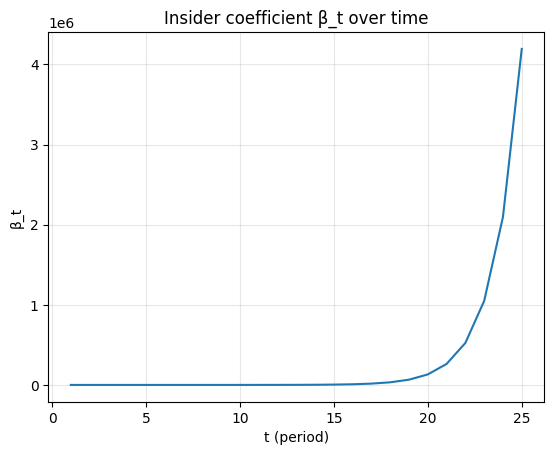

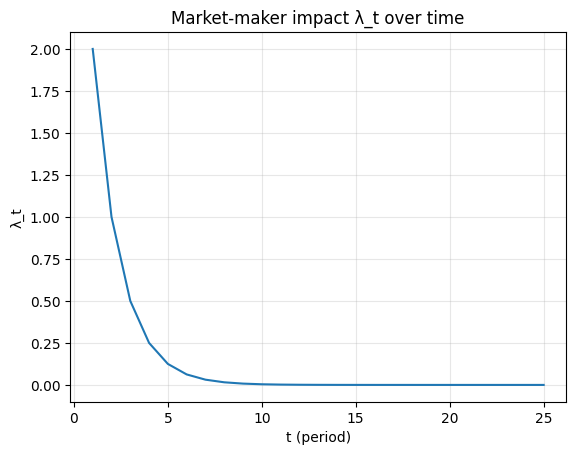

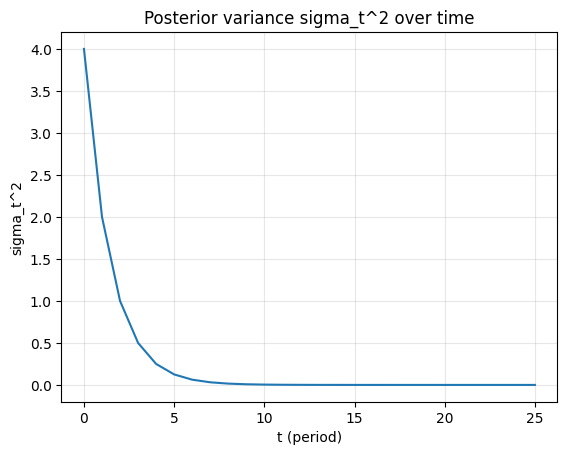

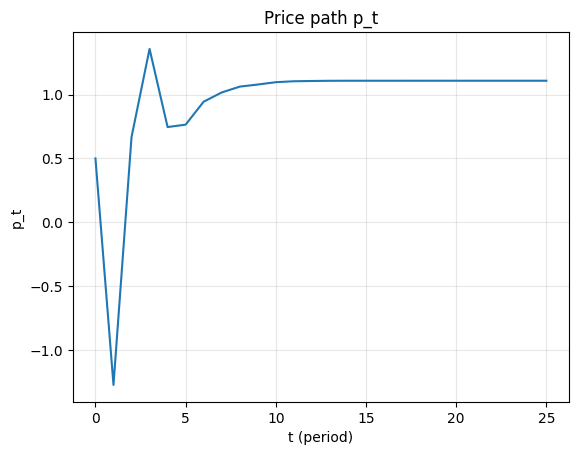

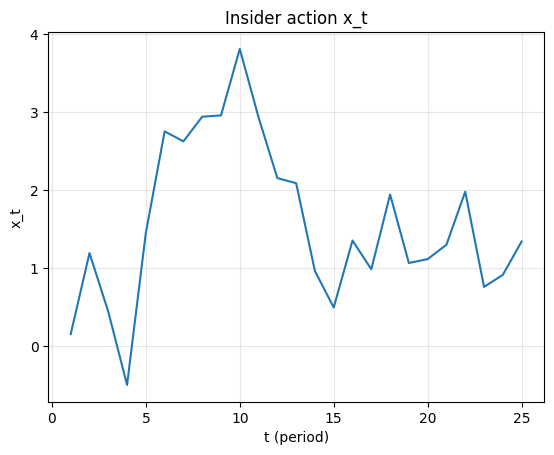

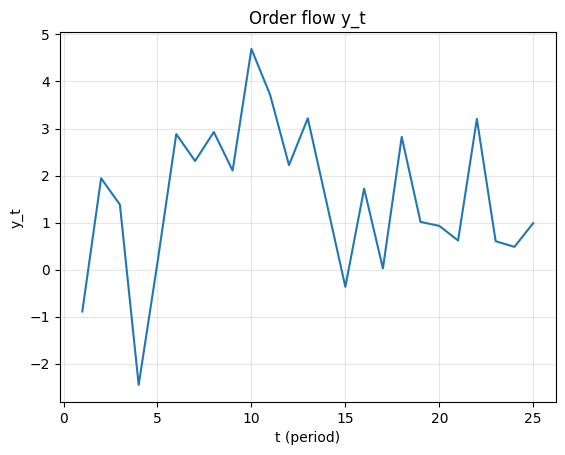

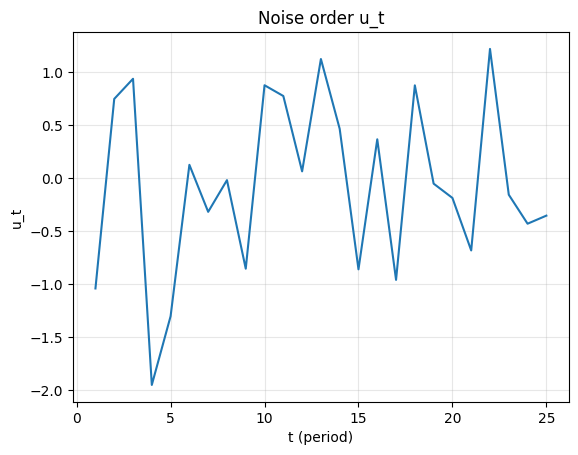

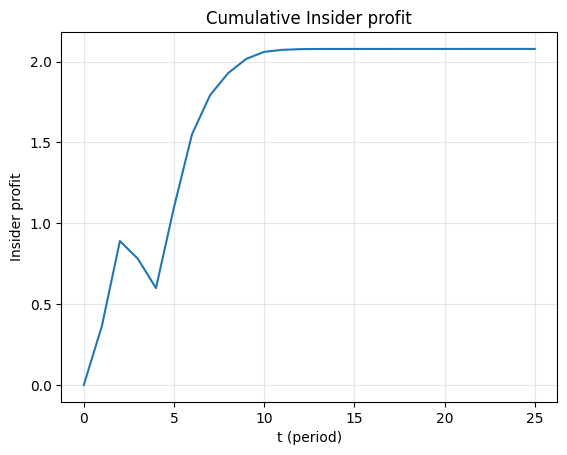

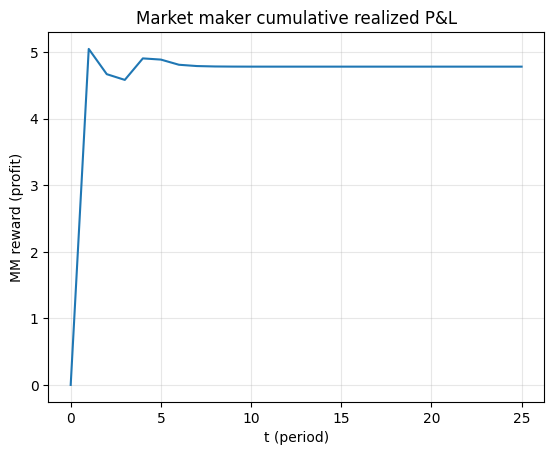

{'v': 1.1094341595088628,
 'p': array([ 0.5       , -1.27525113,  0.66754271,  1.35877079,  0.74634368,
         0.76511648,  0.94526535,  1.01746717,  1.06318815,  1.07964675,
         1.0979756 ,  1.10522401,  1.10739357,  1.10896427,  1.10931335,
         1.10926886,  1.10937402,  1.10937483,  1.1094179 ,  1.10942565,
         1.1094292 ,  1.10943038,  1.10943344,  1.10943372,  1.10943384,
         1.10943396]),
 'x': array([ 0.        ,  0.15235854,  1.19234265,  0.44189145, -0.49867327,
         1.45236192,  2.75454143,  2.62670103,  2.94294362,  2.95974478,
         3.8127887 ,  2.93339073,  2.15559879,  2.0895681 ,  0.96232689,
         0.49481755,  1.35411001,  0.98535923,  1.94424183,  1.06579152,
         1.11571744,  1.3005798 ,  1.98150934,  0.75896801,  0.91349749,
         1.34182531]),
 'y': array([ 0.        , -0.88762557,  1.94279384,  1.38245617, -2.44970845,
         0.15018242,  2.88238183,  2.31045843,  2.92614246,  2.10670085,
         4.69218668,  3.71118266,  2.

In [12]:
plot_kyle_time_series_from_helpers()

In [13]:
class BetaHead(nn.Module):
    """Outputs beta_t >= 0 from obs (tiny MLP)."""
    def __init__(self, obs_dim, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1)
        )
        self.log_std = nn.Parameter(torch.tensor([-0.5]))  # learn exploration
    def forward(self, obs):
        beta = F.softplus(self.net(obs)).squeeze(-1)       # beta_t >= 0
        std  = self.log_std.exp().clamp(1e-4, 10.0)
        return beta, std

class LambdaHead(nn.Module):
    """Outputs lambda_t >= 0 from obs (tiny MLP)."""
    def __init__(self, obs_dim, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, 1)
        )
        self.log_std = nn.Parameter(torch.tensor([-0.5]))
    def forward(self, obs):
        lam = F.softplus(self.net(obs)).squeeze(-1)        # lambda_t >= 0
        std = self.log_std.exp().clamp(1e-4, 10.0)
        return lam, std

class InsiderLinearActor(nn.Module):
    """
    x_t = beta_t * (v - p_{t-1})
    Expect obs to contain at least: [v, p_prev, ...] at indices idx_v, idx_p_prev.
    """
    def __init__(self, obs_dim, idx_v=0, idx_p_prev=1, hidden=32):
        super().__init__()
        self.beta_head = BetaHead(obs_dim, hidden)
        self.idx_v = idx_v
        self.idx_p_prev = idx_p_prev
    def forward(self, obs: torch.Tensor):
        beta, std = self.beta_head(obs)
        v      = obs[..., self.idx_v]
        pprev  = obs[..., self.idx_p_prev]
        mu     = beta * (v - pprev)           # linear Kyle form
        return mu, std

class MMLinearActor(nn.Module):
    """
    p_t = p_{t-1} + lambda_t * y_t   (outputs the **price level** p_t)
    Expect obs to contain at least: [y_t, p_prev, ...] at indices idx_y, idx_p_prev.
    """
    def __init__(self, obs_dim, idx_y=0, idx_p_prev=1, hidden=32):
        super().__init__()
        self.lam_head = LambdaHead(obs_dim, hidden)
        self.idx_y = idx_y
        self.idx_p_prev = idx_p_prev
    def forward(self, obs: torch.Tensor):
        lam, std = self.lam_head(obs)
        y     = obs[..., self.idx_y]
        pprev = obs[..., self.idx_p_prev]
        mu    = pprev + lam * y               # linear Kyle form
        return mu, std

In [14]:
class EquilibriumInsiderPolicy(nn.Module):
    # expects obs ~ [v, p_prev, G, sigma_u, ...] at indices below
    def __init__(self, idx_v=0, idx_p_prev=1, idx_G=2, idx_sigma_u=3):
        super().__init__()
        self.idx_v, self.idx_p_prev = idx_v, idx_p_prev
        self.idx_G, self.idx_su = idx_G, idx_sigma_u
    def forward(self, obs):
        v = obs[..., self.idx_v]
        pprev = obs[..., self.idx_p_prev]
        G = obs[..., self.idx_G]                  # sqrt(sigma2_{t-1})
        su = obs[..., self.idx_su]
        beta = (su**2) / (G**2 + 1e-12)
        mu = beta * (v - pprev)                   # x*_t
        std = torch.full_like(mu, 1e-6)
        return mu, std

class EquilibriumMMPolicy(nn.Module):
    # expects obs ~ [y_t, p_prev, G, sigma_u, ...] (NO v!)
    def __init__(self, idx_y=0, idx_p_prev=1, idx_G=2, idx_sigma_u=3):
        super().__init__()
        self.idx_y, self.idx_p_prev = idx_y, idx_p_prev
        self.idx_G, self.idx_su = idx_G, idx_sigma_u
    def forward(self, obs):
        y = obs[..., self.idx_y]
        pprev = obs[..., self.idx_p_prev]
        G = obs[..., self.idx_G]
        su = obs[..., self.idx_su]
        lam = (G**2) / (2.0 * su**2 + 1e-12)
        mu = pprev + lam * y                        # p*_t
        std = torch.full_like(mu, 1e-6)
        return mu, std


In [15]:
from collections import defaultdict
import matplotlib.pyplot as plt
def _sanitize_obs(obs_t: torch.Tensor, who: str, ep: int, step: int):
    if not torch.isfinite(obs_t).all():
        print(f"[TRAIN WARN] Non-finite obs for {who} at ep={ep} step={step}:",
              obs_t.detach().cpu().numpy())
        obs_t = torch.nan_to_num(obs_t, nan=0.0, posinf=1e6, neginf=-1e6)
    return obs_t

def _sanitize_mu_std(mu: torch.Tensor, std: torch.Tensor, who: str, ep: int, step: int):
    ok = torch.isfinite(mu).all() and torch.isfinite(std).all()
    if not ok:
        print(f"[TRAIN WARN] Non-finite mu/std for {who} at ep={ep} step={step}:",
              "mu=", mu.detach().cpu().numpy(), "std=", std.detach().cpu().numpy())
    mu  = torch.nan_to_num(mu,  nan=0.0, posinf=1e6, neginf=-1e6)
    std = torch.nan_to_num(std, nan=0.5, posinf=10.0, neginf=1e-3).clamp(1e-6, 10.0)
    return mu, std

def _indexable_action(x: torch.Tensor, scale: float = 1.0):
    val = (x * scale).detach().cpu().item()
    return np.array([val], dtype=np.float32)   # so env.step can do action[0]
def train_one_agent_vs_equilibrium(
    agent_to_train: str,                 # "insider" or "market_maker"
    train_policy: nn.Module,
    env,
    *,
    num_episodes=3000,
    lr=1e-3,
    entropy_coef=1e-3,
    grad_clip=1.0,
    action_scaling=1.0,
    insider_obs_idx=(0,1,2,3),
    mm_obs_idx=(0,1,2,3),
):
    assert agent_to_train in {"insider","market_maker"}

    # fixed opponent at equilibrium
    if agent_to_train == "insider":
        policies = {"insider": train_policy,
                    "market_maker": EquilibriumMMPolicy(*mm_obs_idx).eval()}
    else:
        policies = {"insider": EquilibriumInsiderPolicy(*insider_obs_idx).eval(),
                    "market_maker": train_policy}

    opt = torch.optim.Adam(train_policy.parameters(), lr=lr)

    for ep in range(num_episodes):
        env.reset()
        log_probs = {"insider": [], "market_maker": []}
        entropies = {"insider": [], "market_maker": []}
        rewards   = {"insider": [], "market_maker": []}
        done = False
        step = 0

        while not done and getattr(env, "agents", []):
            # ----- Insider step -----
            assert env.agent_selection == "insider"
            obsI = torch.as_tensor(env.observe("insider"), dtype=torch.float32)
            obsI = _sanitize_obs(obsI, "insider-obs", ep, step)
            muI, stdI = policies["insider"](obsI)
            muI, stdI = _sanitize_mu_std(muI, stdI, "insider", ep, step)
            distI = torch.distributions.Normal(muI, stdI)
            aI = distI.sample()
            lpI = distI.log_prob(aI).sum(); entI = distI.entropy().sum()
            env.step(_indexable_action(aI, action_scaling))
            log_probs["insider"].append(lpI); entropies["insider"].append(entI)

            if hasattr(env, "terminations") and any(env.terminations.values()): break
            if hasattr(env, "truncations")  and any(env.truncations.values()):  break
            if not env.agents: break

            # ----- MM step (ends the period; rewards now valid) -----
            assert env.agent_selection == "market_maker"
            obsM = torch.as_tensor(env.observe("market_maker"), dtype=torch.float32)
            obsM = _sanitize_obs(obsM, "mm-obs", ep, step)
            muM, stdM = policies["market_maker"](obsM)
            muM, stdM = _sanitize_mu_std(muM, stdM, "mm", ep, step)
            distM = torch.distributions.Normal(muM, stdM)
            aM = distM.sample()
            lpM = distM.log_prob(aM).sum(); entM = distM.entropy().sum()
            env.step(_indexable_action(aM, action_scaling))
            log_probs["market_maker"].append(lpM); entropies["market_maker"].append(entM)

            # append period rewards (created by MM step)
            rewards["insider"].append(env.rewards["insider"])
            rewards["market_maker"].append(env.rewards["market_maker"])

            if hasattr(env, "terminations") and any(env.terminations.values()): done = True
            if hasattr(env, "truncations")  and any(env.truncations.values()):  done = True
            if not env.agents: done = True

            step += 1

        # update ONLY the trainable agent
        a = agent_to_train
        if len(log_probs[a]) and len(rewards[a]):
            G = torch.tensor(sum(rewards[a]), dtype=torch.float32)
            lp_sum = torch.stack(log_probs[a]).sum()
            ent    = torch.stack(entropies[a]).sum()
            loss = -(lp_sum * G) - entropy_coef * ent

            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(train_policy.parameters(), grad_clip)
            opt.step()

        if (ep + 1) % max(1, num_episodes // 10) == 0:
            print(f"[{agent_to_train} vs EQ] ep {ep+1}/{num_episodes} | "
                  f"R_I={sum(rewards['insider']) if rewards['insider'] else 0:.3f} "
                  f"| R_MM={sum(rewards['market_maker']) if rewards['market_maker'] else 0:.3f}")

    return train_policy





In [59]:
def kyle_posterior_vars(sigma_v: float, T=25):
    sigma2 = np.empty(T + 1, float)
    sigma2[0] = float(sigma_v) ** 2
    for t in range(1, T + 1):
        sigma2[t] = 0.5 * sigma2[t - 1]
    return sigma2

def get_kyle_eq_params_path(sigma_v: float, sigma_u: float, T: int = 25):
    """
    Kyle equilibrium coefficients:
      beta_t   = sigma_u^2 / G_{t-1}^2
      lambda_t = G_{t-1}^2 / (2 * sigma_u^2)
    where G_{t-1}^2 = sigma_{t-1}^2 and sigma_t^2 = 0.5 * sigma_{t-1}^2.
    """
    sigma2 = kyle_posterior_vars(sigma_v, T)
    su2 = float(sigma_u) ** 2
    beta = np.empty(T + 1); lam = np.empty(T + 1)
    beta[0] = np.nan; lam[0] = np.nan
    for t in range(1, T + 1):
        G2 = sigma2[t - 1]
        beta[t] = su2 / G2
        lam[t] = G2 / (2.0 * su2 )
    return beta, lam, sigma2

def softplus_inv_torch(x, eps=1e-12):
    # Inverse of softplus: y = log(1 + e^z) => z = log(e^y - 1)
    x = torch.clamp(x, min=eps)
    return torch.log(torch.expm1(x))

class EquilibriumInsiderActionPolicy(nn.Module):
    """
    Returns action a_I in [-1,1]; x_t = a_I * action_scaling.
    With large action_scaling, tanh is ~ identity and x_t ≈ x*_t.
    obs = [v, p_prev, G, sigma_u, t/T]
    """
    def __init__(self, action_scaling: float):
        super().__init__()
        self.ascale = float(action_scaling)
    def forward(self, obs: torch.Tensor):
        v, pprev, G, su = obs[..., 0], obs[..., 1], obs[..., 2], obs[..., 3]
        beta = (su ** 2) / (G ** 2 + 1e-12)
        x_star = beta * (v - pprev)
        a = torch.tanh(x_star / self.ascale)
        std = torch.full_like(a, 1e-6)
        return a, std

class EquilibriumMMActionPolicy(nn.Module):
    """
    Returns action a_MM in [-1,1]; lambda_t = softplus(a_MM * lambda_scaling).
    With large lambda_scaling, tanh(pre / scale) ≈ pre / scale, yielding λ_t ≈ λ*_t.
    obs = [y_t, p_prev, G, sigma_u, t/T] (y_t, p_prev unused for λ*_t)
    """
    def __init__(self, lambda_scaling: float):
        super().__init__()
        self.lscale = float(lambda_scaling)
    def forward(self, obs: torch.Tensor):
        G, su = obs[..., 2], obs[..., 3]
        lam_star = (G ** 2) / (2.0 * su ** 2 + 1e-12)
        pre = softplus_inv_torch(lam_star)
        a = torch.tanh(pre / self.lscale)
        std = torch.full_like(a, 1e-6)
        return a, std

@torch.no_grad()
def simulate_rl_vs_true_equilibrium(
    insider_net: nn.Module,
    mm_net: nn.Module,
    *,
    T=25, p0=0.5, sigma_v=2.0, sigma_u=1.0, seed=7,
    action_scaling=100.0, lambda_scaling=100.0,
):
    """
    Build two paths:
      - RL path: actions from (insider_net, mm_net) mapped via x = a_I * action_scaling,
                 λ = softplus(a_MM * lambda_scaling), p_t = p_{t-1} + λ y_t
      - EQ path: direct Kyle formulas
    With large scales, RL ≈ EQ (no saturation).
    """
    rng = np.random.default_rng(seed)
    beta, lam, sigma2 = get_kyle_eq_params_path(sigma_v, sigma_u, T)
    v = float(rng.normal(p0, sigma_v))
    u = rng.normal(0.0, sigma_u, size=T+1);u[0]=0

    # RL containers
    p_rl = np.empty(T + 1); p_rl[0] = p0
    x_rl = np.empty(T+1); y_rl = np.empty(T+1);x_rl[0]=y_rl[0]=0
    rI_rl = np.zeros(T+1); mm_rl = np.zeros(T+1)

    # EQ containers
    p_eq = np.empty(T + 1); p_eq[0] = p0
    x_eq = np.empty(T+1); y_eq = np.empty(T+1);x_eq[0]=y_eq[0]=0
    rI_eq = np.zeros(T+1); mm_eq = np.zeros(T+1)

    for t in range(1, T + 1):
        G = float(np.sqrt(sigma2[t - 1]))
        lam_t = float(lam[t])
        beta_t = float(beta[t])

        # RL insider (action -> x)
        obs_I = torch.tensor([v, p_rl[t-1], G, sigma_u, t / T], dtype=torch.float32)
        a_I, _ = insider_net(obs_I)
        a_I = float(torch.tanh(a_I))  # ensure in [-1,1]
        x_rl[t] = a_I * action_scaling
        y_rl[t] = x_rl[t] + u[t]

        # RL MM (action -> λ)
        obs_M = torch.tensor([y_rl[t-1], p_rl[t-1], G, sigma_u, t / T], dtype=torch.float32)
        a_M, _ = mm_net(obs_M)
        a_M = float(torch.tanh(a_M))
        lam_rl = float(np.log1p(np.exp(a_M * lambda_scaling)))
        p_rl[t] = p_rl[t-1] + lam_rl * y_rl[t]

        rI_rl[t] = x_rl[t] * (v - p_rl[t])
        mm_rl[t] = - ((p_rl[t] - v) ** 2)*y_rl[t]

        # EQ path
        x_eq[t] = beta_t * (v - p_eq[t-1])
        y_eq[t] = x_eq[t] + u[t]
        p_eq[t]   = p_eq[t-1] + lam_t * y_eq[t]
        rI_eq[t] = x_eq[t] * (v - p_eq[t])
        mm_eq[t] = - ((p_eq[t] - v) ** 2)*y_eq[t]

    return {
        "v": v, "u": u, "beta": beta, "lambda": lam, "sigma2": sigma2,
        "p_rl": p_rl, "x_rl": x_rl, "y_rl": y_rl, "rI_rl": rI_rl, "mm_loss_rl": mm_rl,
        "p_eq": p_eq, "x_eq": x_eq, "y_eq": y_eq, "rI_eq": rI_eq, "mm_loss_eq": mm_eq,
        "action_scaling": action_scaling, "lambda_scaling": lambda_scaling,
    }

def plot_true_paths_vs_time(out, title_suffix=""):
    T = len(out["x_rl"])
    t = np.arange(1, T + 1)
    t0 = np.arange(0, T + 1)

    # Insider action
    plt.figure()
    plt.plot(t, out["x_rl"], label="RL $x_t$")
    plt.plot(t, out["x_eq"], "--", label="EQ $x_t^*$")
    plt.title(f"Insider action per period {title_suffix}")
    plt.xlabel("t"); plt.ylabel("$x_t$")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

    # Price path
    plt.figure()
    plt.plot(t, out["p_rl"], label="RL $p_t$")
    plt.plot(t, out["p_eq"], "--", label="EQ $p_t^*$")
    plt.title(f"MM price path {title_suffix}")
    plt.xlabel("t"); plt.ylabel("$p_t$")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

    # Cumulative insider profit
    plt.figure()
    plt.plot(t, np.cumsum(out["rI_rl"]), label="RL cum insider")
    plt.plot(t, np.cumsum(out["rI_eq"]), "--", label="EQ cum insider")
    plt.title(f"Cumulative insider profit {title_suffix}")
    plt.xlabel("t"); plt.ylabel("Profit")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()

In [52]:
env.reset()
print("Sample INS obs:", env.observe("insider"))
print("Sample  MM obs:", env.observe("market_maker"))

Sample INS obs: [1.2964127 0.5       4.        1.        4.       ]
Sample  MM obs: [0.5 4.  1.  0.  4. ]


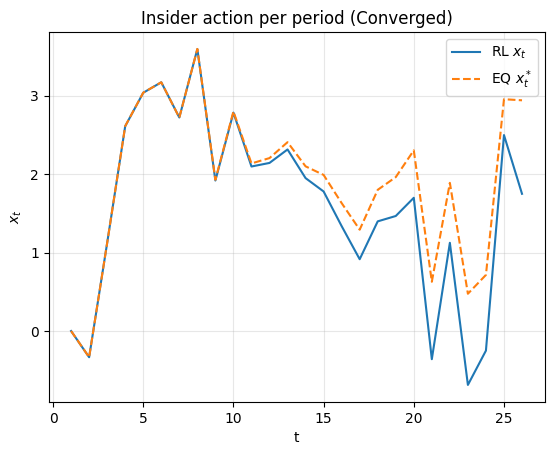

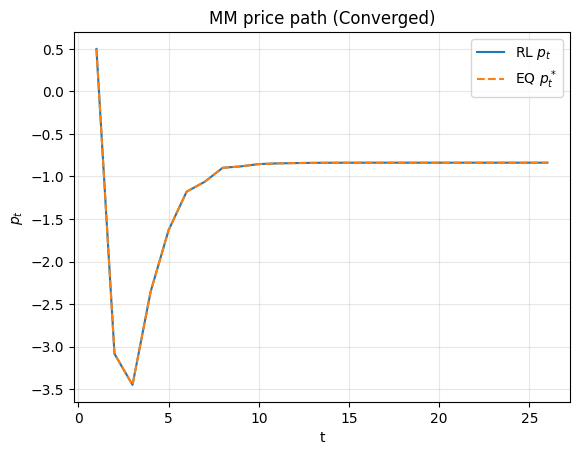

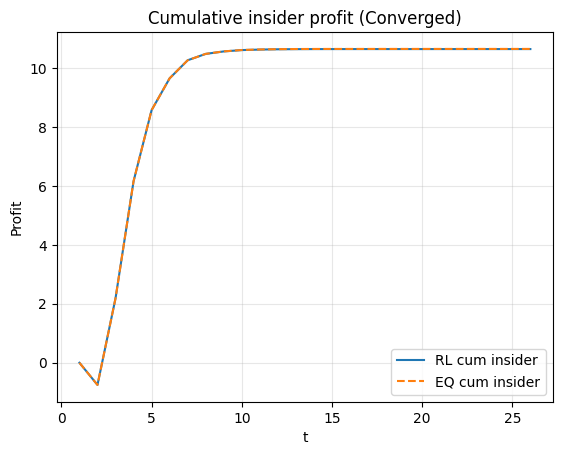

In [60]:
if __name__ == "__main__":
    # Large scales avoid tanh/softplus saturation so RL≈EQ numerically
    action_scaling = 100.0
    lambda_scaling = 100.0

    insider_eq = EquilibriumInsiderActionPolicy(action_scaling).eval()
    mm_eq = EquilibriumMMActionPolicy(lambda_scaling).eval()

    out = simulate_rl_vs_true_equilibrium(
        insider_eq, mm_eq,
        T=25, p0=0.5, sigma_v=2.0, sigma_u=1.0, seed=321,
        action_scaling=action_scaling, lambda_scaling=lambda_scaling
    )

    plot_true_paths_vs_time(out, "(Converged)")